In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import pandas as pd
import scanpy as sc
import squidpy as sq
import anndata as ad
import scipy as sp

In [2]:
adata = sc.read_h5ad('../../data/from_spatial_omics/Stereo-seq/Stereo-seq_wang2022high_E14-16h_a_count_normal_stereoseq_data_whole.h5ad')

In [3]:
adata.layers['counts'] = adata.X.copy()

adata.obs['time_point'] = adata.obsm['spatial'][:, 2]
adata.obsm['spatial'] = adata.obsm['spatial'][:, :2]

adata.obs['time_point'].value_counts()

time_point
4.9     1272
5.6     1263
7.7     1260
6.3     1248
9.8     1240
10.5    1110
9.1     1078
7.0     1039
8.4      959
4.2      925
3.5      815
2.8      744
2.1      713
1.4      598
0.7      549
0.0      482
Name: count, dtype: int64

In [4]:
adata = adata[adata.obs['time_point'] == 9.1]

In [5]:
adata

View of AnnData object with n_obs × n_vars = 1078 × 13668
    obs: 'annotation', 'leiden', 'time_point'
    uns: 'leiden', 'leiden_colors', 'moranI', 'neighbors', 'pca', 'spatial_neighbors', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    layers: 'raw_counts', 'counts'
    obsp: 'connectivities', 'distances', 'spatial_connectivities', 'spatial_distances'

In [6]:
sc.pp.filter_cells(adata, min_genes=10)
sc.pp.filter_genes(adata, min_cells=50)

In [7]:
adata

AnnData object with n_obs × n_vars = 1078 × 811
    obs: 'annotation', 'leiden', 'time_point', 'n_genes'
    var: 'n_cells'
    uns: 'leiden', 'leiden_colors', 'moranI', 'neighbors', 'pca', 'spatial_neighbors', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    layers: 'raw_counts', 'counts'
    obsp: 'connectivities', 'distances', 'spatial_connectivities', 'spatial_distances'

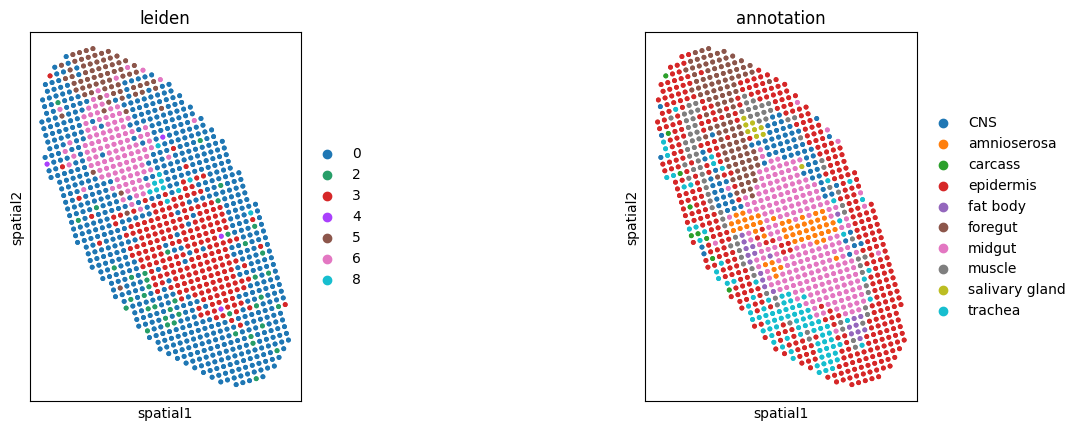

In [8]:
sq.pl.spatial_scatter(adata, color=['leiden', 'annotation'], size=25, shape=None)

In [9]:
# remove MT genes
non_mito_genes_list = [name for name in adata.var_names if not name.startswith('mt-')]
adata = adata[:, non_mito_genes_list]

In [10]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

In [11]:
sq.gr.spatial_neighbors(adata, coord_type="generic", delaunay=True)
sq.gr.spatial_autocorr(adata, mode="moran", 
                       n_perms=100, n_jobs=1, 
                       genes=adata.var_names)

100%|██████████| 100/100 [00:09<00:00, 10.24/s]


In [12]:
n_svgs = 50
sel_genes = (
    adata.uns["moranI"]["I"].sort_values(ascending=False).head(n_svgs).index.tolist()
)

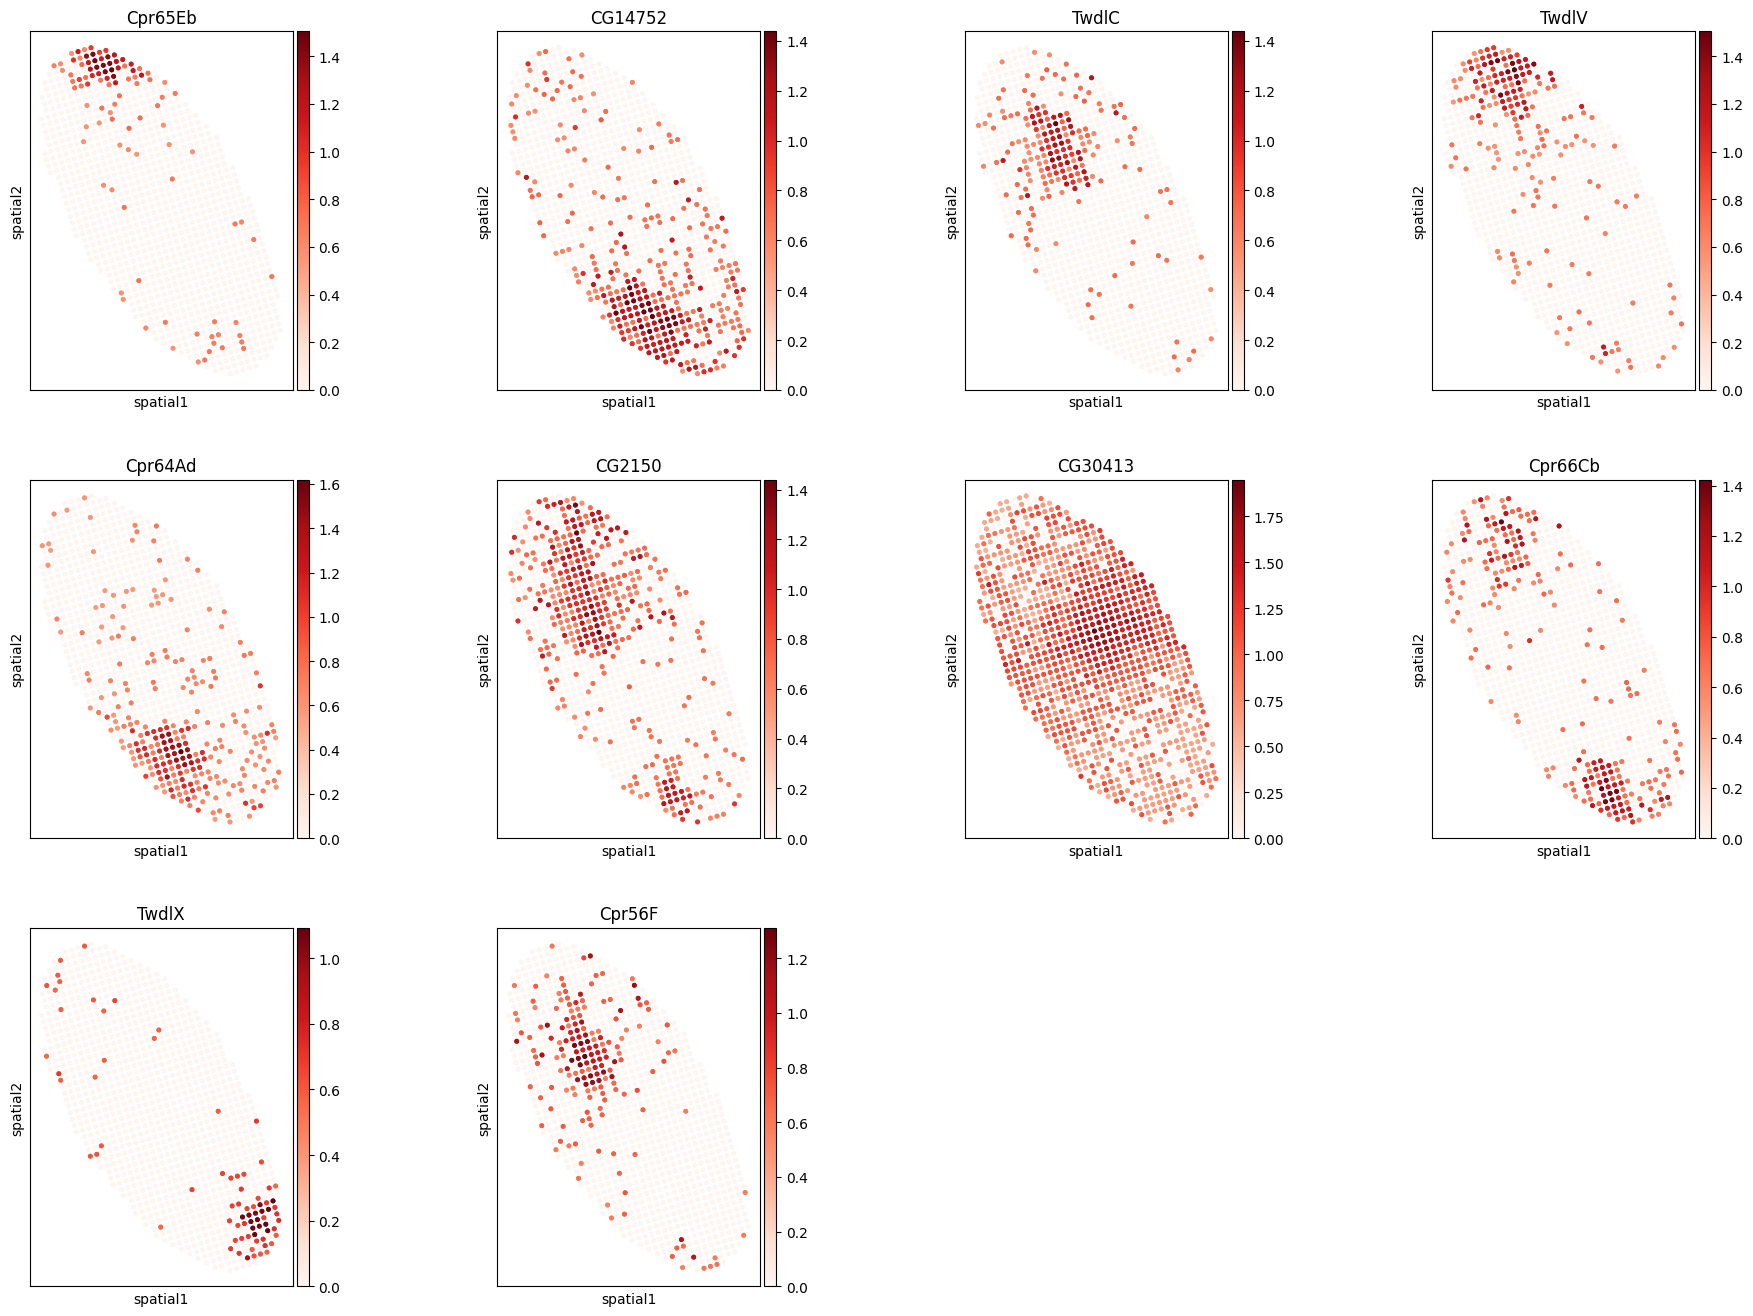

In [13]:
sq.pl.spatial_scatter(
    adata, color=sel_genes[:10], figsize=(5, 5), size=25, 
    cmap="Reds", shape=None, use_raw=False
)

In [14]:
# select top 50 variable genes as reference
adata = adata[:, sel_genes]

In [15]:
adata.write_h5ad('../../results/00_prepare_reference_data/45_stereo_seq_Drosophila_embryo_E9.1.h5ad')